In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score


ap_r11 = pd.read_csv('apartments_rent_pl_2023_11.csv')
ap_r12 = pd.read_csv('apartments_rent_pl_2023_12.csv')
ap_r01 = pd.read_csv('apartments_rent_pl_2024_01.csv')

population = pd.read_csv('cities_population.csv')

In [2]:
rent = pd.concat([ap_r11, ap_r12, ap_r01], ignore_index=True)

In [3]:
rent

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,2a1a6db97ff122d6bc148abb6f0e498a,szczecin,blockOfFlats,52.0,2.0,3.0,3.0,2008.0,53.460535,14.545416,...,0.307,condominium,brick,NaN,yes,yes,no,no,no,3500
1,5a0cb42c088eadf75aa98a4118640048,szczecin,blockOfFlats,57.0,3.0,NaN,10.0,1976.0,53.440955,14.566024,...,0.189,condominium,NaN,premium,no,yes,yes,no,no,3000
2,996722490efcb4b34d48bb84a9a72838,szczecin,NaN,43.4,2.0,3.0,4.0,NaN,53.435746,14.560764,...,0.211,condominium,NaN,NaN,no,yes,no,no,no,1900
3,50d75c688530b9a61ba505301e0b94a9,szczecin,apartmentBuilding,32.6,2.0,5.0,6.0,2021.0,53.421582,14.541572,...,0.192,condominium,brick,premium,no,yes,yes,no,no,2500
4,9b187f4203adabf466fd08610d8f4e5e,szczecin,apartmentBuilding,72.0,3.0,6.0,6.0,2014.0,53.450010,14.547230,...,0.315,condominium,brick,premium,no,yes,yes,no,yes,2999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25830,aeb9ea42eecfe32b2f791efe372a2e76,bydgoszcz,tenement,45.0,2.0,1.0,1.0,NaN,53.129551,18.029431,...,0.024,condominium,brick,NaN,no,no,NaN,no,no,2500
25831,4018cc5a9fd48bb2d66b84bc5e1b46ab,bydgoszcz,tenement,55.0,3.0,2.0,2.0,NaN,53.129551,18.029431,...,0.024,condominium,brick,NaN,no,no,no,no,no,3200
25832,89fdf9ecda6fe6aa95e34528fa82f55f,bydgoszcz,blockOfFlats,48.0,2.0,3.0,3.0,2019.0,53.121200,17.992500,...,0.300,condominium,brick,NaN,no,no,no,no,no,2700
25833,095b187d0bbce092d4b03164e89710c5,bydgoszcz,blockOfFlats,50.0,2.0,1.0,3.0,2019.0,53.121200,17.992500,...,0.300,condominium,brick,NaN,no,yes,no,no,no,2800


In [4]:
# sprawdzamy ile jest nulli w rent
rent.isnull().sum()

id                          0
city                        0
type                     6764
squareMeters                0
rooms                       0
floor                    3096
floorCount                552
buildYear                7819
latitude                    0
longitude                   0
centreDistance              0
poiCount                    0
schoolDistance              9
clinicDistance             23
postOfficeDistance         14
kindergartenDistance       26
restaurantDistance         76
collegeDistance           318
pharmacyDistance           38
ownership                   0
buildingMaterial        10644
condition               19130
hasParkingSpace             0
hasBalcony                  0
hasElevator              1467
hasSecurity                 0
hasStorageRoom              0
price                       0
dtype: int64

In [5]:
# usuwamy kolumny id, latitude, longitude, ownership (zbędne) i condition (nie ma istotnego wpływu na naszą analizę, a ma dużo braków)
rent = rent.drop(columns=['id', 'latitude', 'longitude', 'ownership', 'condition'])

# zastępujemy braki danych w kolumnie floor, jeżeli floorCount przyjmuje wartość 1
# logicznie mieszkanie również musi się wtedy mieścić na piętrze 1/parterze
rent.loc[rent['floorCount'] == 1, 'floor'] = 1

# usuwamy pozostałe braki danych
rent = rent.dropna()
rent = rent.reset_index(drop=True)

# dodajemy kolumnę z ceną za m2
rent['pricePSM'] = rent['price'] / rent['squareMeters']

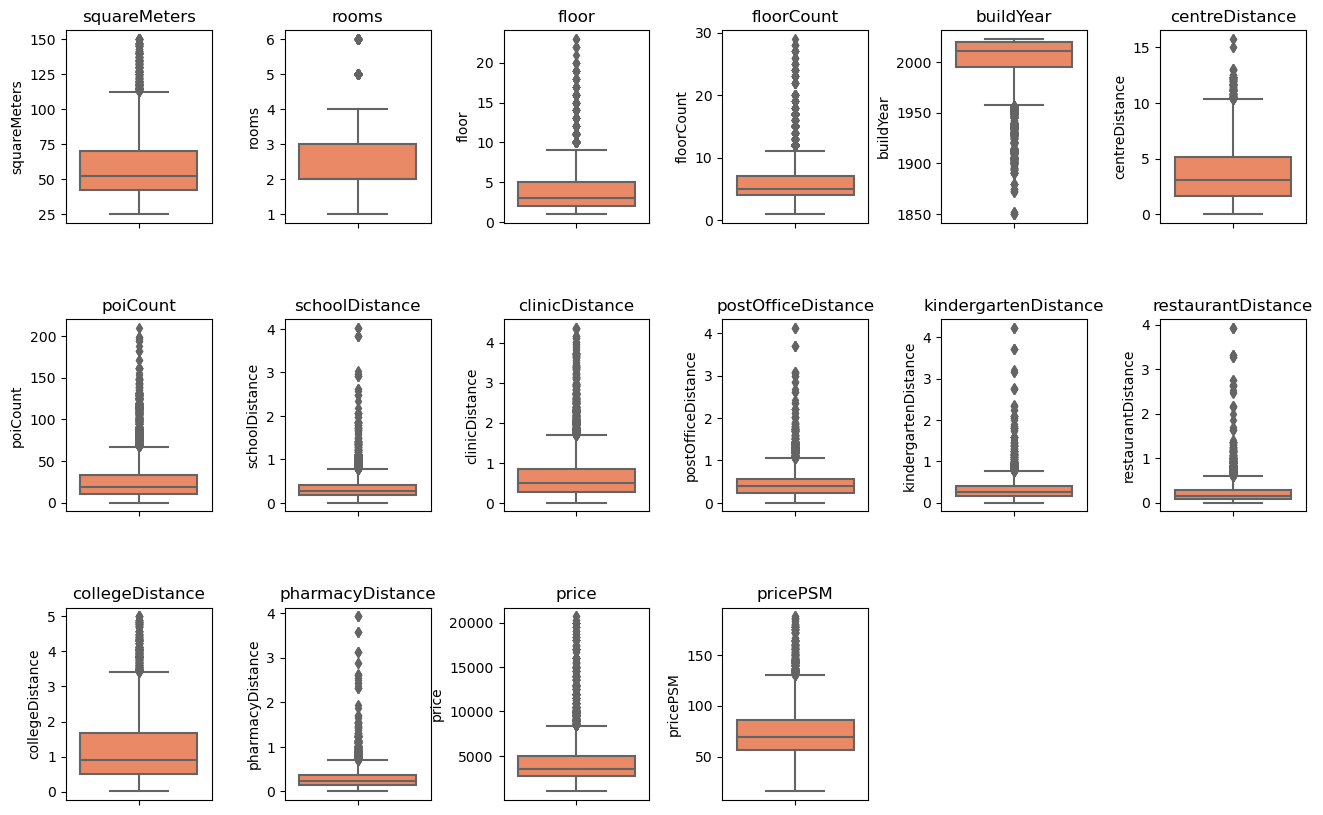

In [6]:
# wybór kolumn numerycznych
num_cols = rent.select_dtypes(['float64', 'int64']).columns
rent_nums = rent[num_cols].reset_index(drop=True)

# wybór kolumn kategorialnych
cat_cols = rent.select_dtypes(['object']).columns
rent_cats = rent[cat_cols].reset_index(drop=True)

num_features = num_cols.to_list()
cat_features = cat_cols.to_list()

# box plots - aby zobaczyć rozkład wartości
plt.figure(figsize=(16,10))
for i in range(0, len(num_features)):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(y = rent_nums[num_features[i]], color = 'coral', orient = 'v')
    plt.title(num_features[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

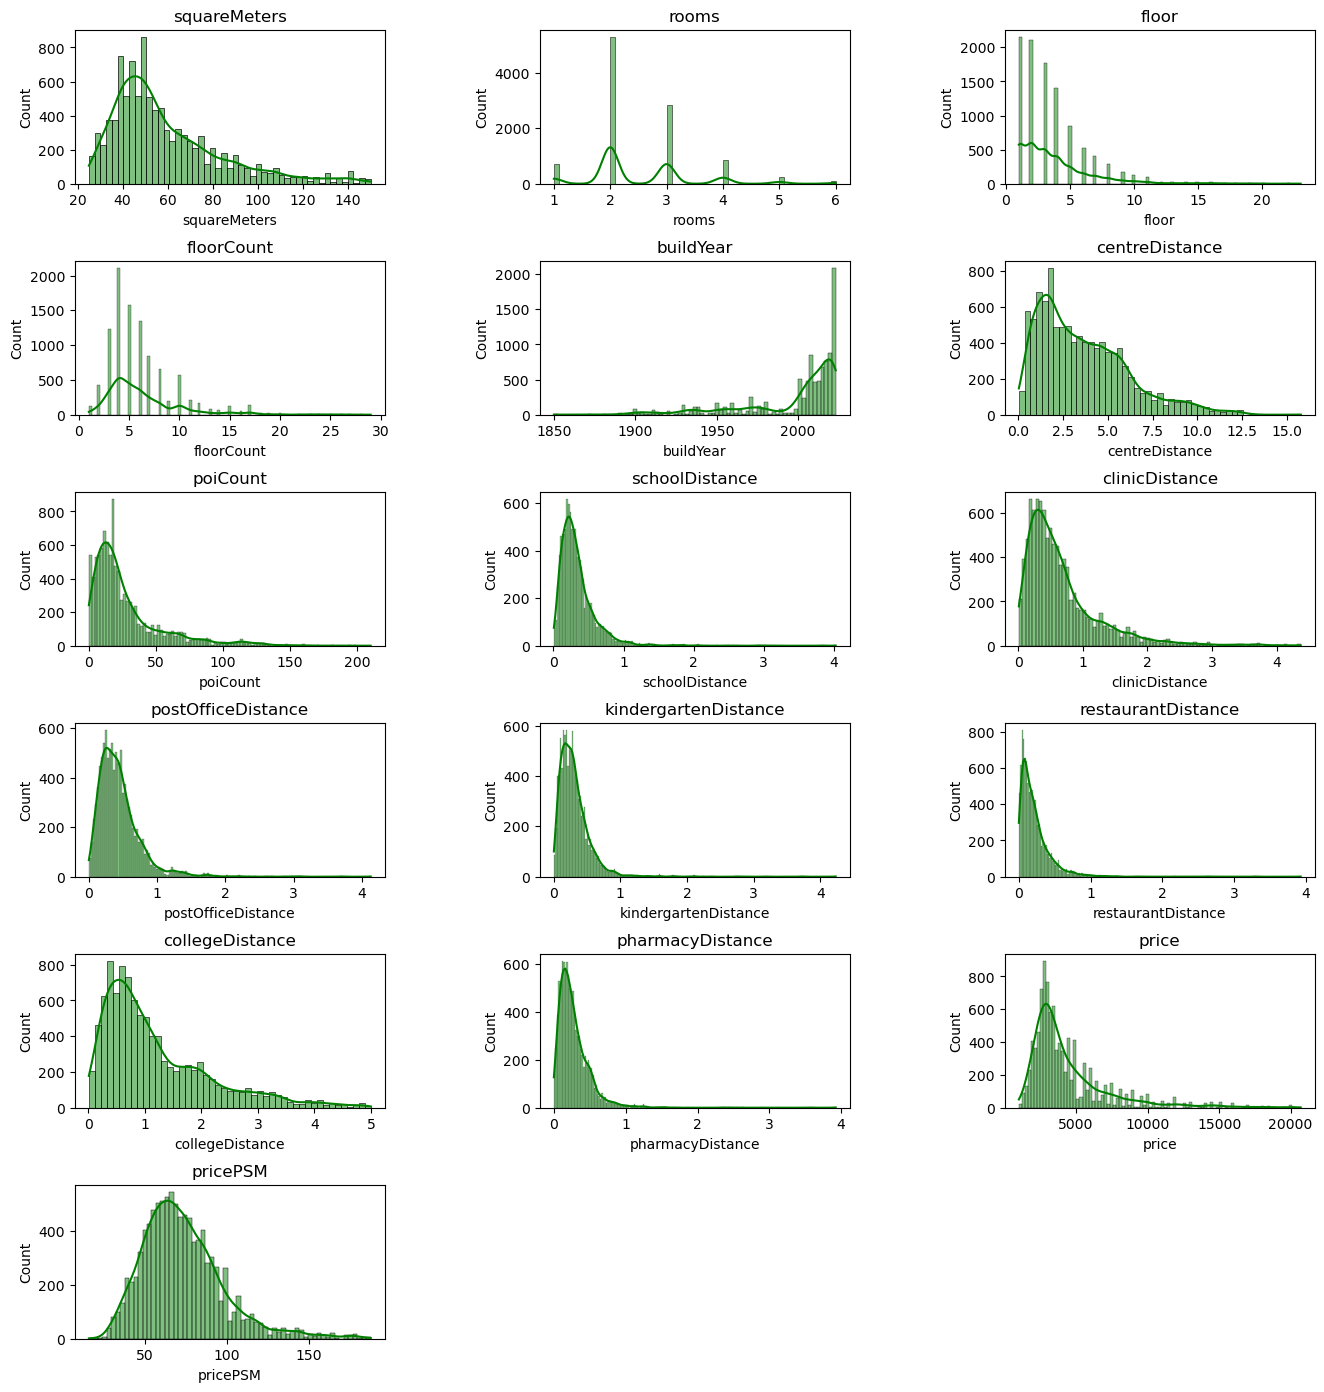

In [7]:
# histogramy - aby dokładniej przyjrzeć się wartościom w zbiorze
plt.figure(figsize = (16, 20))
for i in range(0, len(num_features)):
    plt.subplot(7,3, i+1)
    sns.histplot(x = rent[num_features[i]], kde = True, color = 'green')
    plt.title(num_features[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [8]:
# funkcja do usuwania outlierów metodą 1,5*IQR
def find_outlier(df, column):
    # obliczamy 1 i 3 kwartyl
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    
    # obliczamy rozstęp ćwiartkowy
    IQR = q3 - q1
    
    # obliczamy górną i dolną granicę
    # przypadek jest odstający jeżeli leży co najmniej 1,5*IQR powyżej trzeciego kwartyla lub poniżej pierwszego kwartyla
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    df = df[df[column] > lower_bound]
    df = df[df[column] < upper_bound]
    return df.reset_index(drop=True)

# usuwamy wartości odstające z'poiCount' i 'centreDistance' 
rent = find_outlier(rent, 'poiCount')
rent = find_outlier(rent, 'centreDistance')

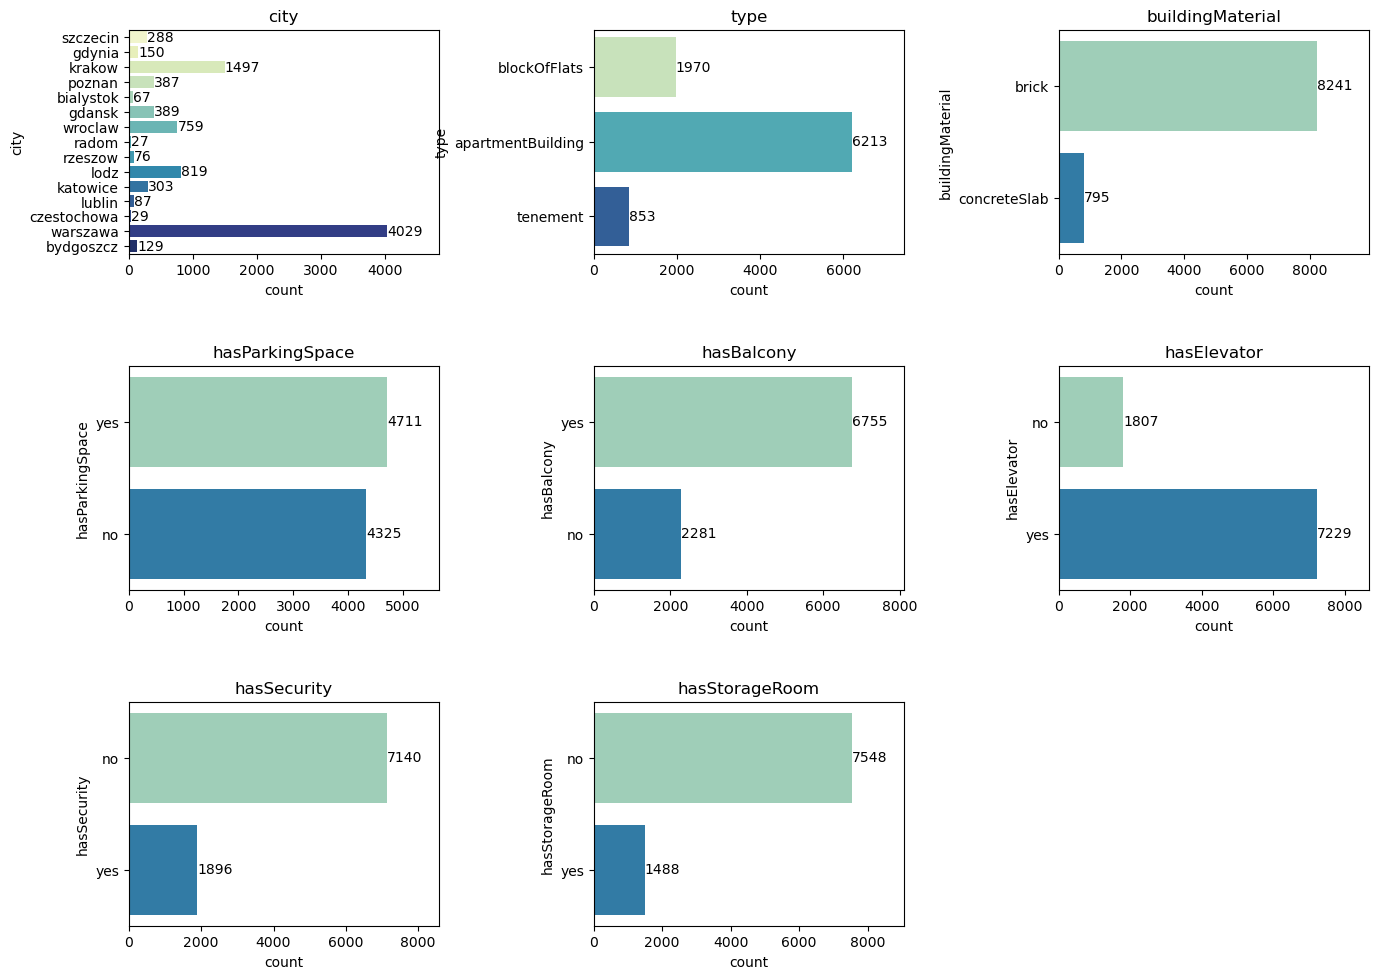

In [9]:
# countplot - aby zobaczyć rozkład wartości kategorialnych
plt.figure(figsize=(16,16))
for i in range(0, len(cat_features)):
    plt.subplot(4, 3, i+1)
    ax = sns.countplot(y = rent[cat_features[i]], palette = 'YlGnBu', orient = 'v')
    ax.set_xlim(0,rent[cat_features[i]].value_counts().max()+rent[cat_features[i]].value_counts().max()*0.2)
    ax.bar_label(ax.containers[0]);
    plt.title(cat_features[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [10]:
# zamieniamy miasta z 'city' na liczbę mieszkańców wybranego miasta 
rent['city'] = rent['city'].map(population.set_index('city')['population'])
rent.rename(columns={'city':'population'}, inplace=True)

cat_features.remove('city')
num_features.append('population')

rent_og = rent.copy()
# zamieniamy zmienne kategorialne na numeryczne
maping = {'yes': 1, 'no': 0,
         'tenement': 0, 'blockOfFlats': 1, 'apartmentBuilding': 2,
         'concreteSlab': 0,'brick': 1}

rent[cat_features] = rent[cat_features].applymap(lambda x: maping.get(x, x))

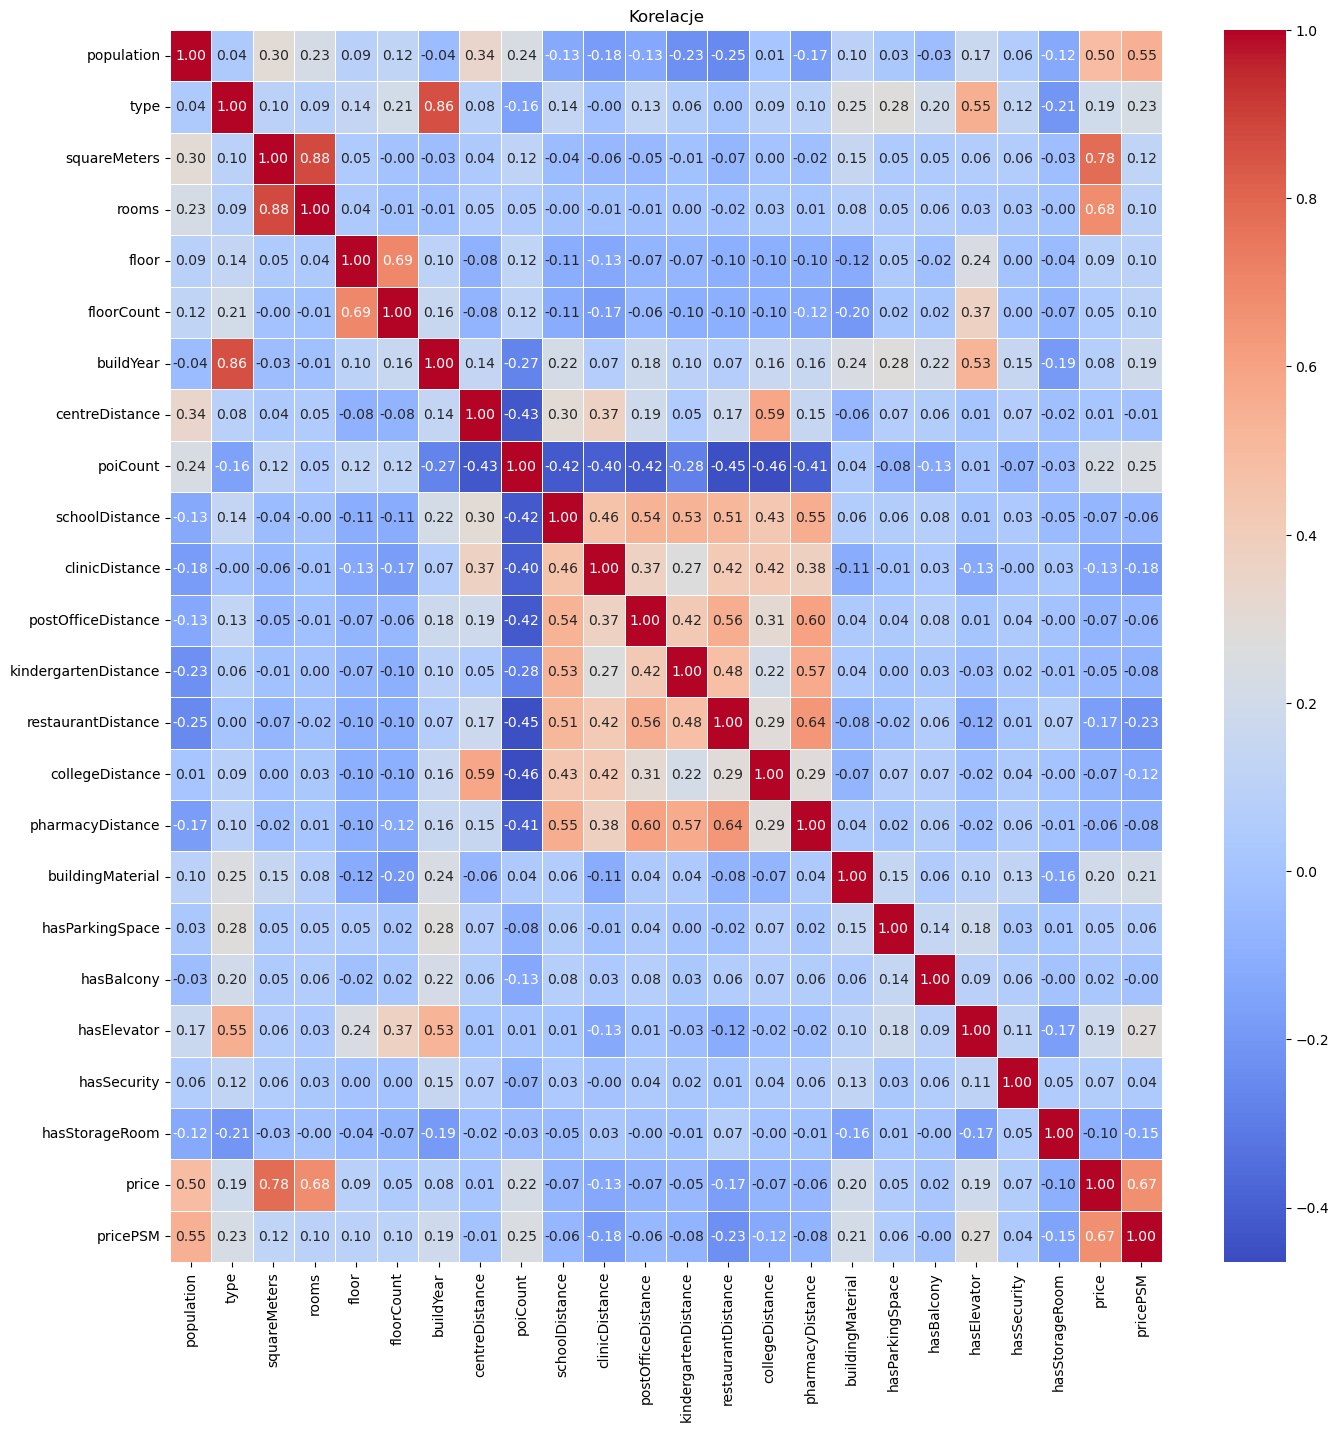

In [11]:
# macierz korelacji
rent_corr_matrix = rent.corr()

# heatmapa korelacji
plt.figure(figsize=(16, 16))
sns.heatmap(rent_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelacje')
plt.show()

In [12]:
# zmienne dotyczące dystansu obiektów są mocno ze sobą skorelowane - występuje współliniowość
# stosujemy PCA, aby skumulować skorelowane ze sobą zmienne dt. dystansu obiektów w jeden indeks 'DistancePCA'

distance_columns = ['centreDistance', 'schoolDistance', 'clinicDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance']

# standaryzacja danych
scaler = StandardScaler()
scaled_distances = scaler.fit_transform(rent[distance_columns])

# zastosowanie PCA z jedną składową główną - chcemy mieć jeden indeks
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_distances)

# df z wynikami
pca_df = pd.DataFrame(data=pca_result, columns=['distancePCA'])

# załadowania obrazujące jak każda zmienna odległości wpływa na składową główną (indeks)
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC'], index=distance_columns)
print(loadings_df)
print(f'Procent wariancji wyjaśniony przez składową główną: {pca.explained_variance_ratio_}')

                            PC
centreDistance        0.226541
schoolDistance        0.409305
clinicDistance        0.333118
postOfficeDistance    0.381732
kindergartenDistance  0.338871
restaurantDistance    0.390993
collegeDistance       0.306645
pharmacyDistance      0.403387
Procent wariancji wyjaśniony przez składową główną: [0.4802914]


In [13]:
# nowa tabela z wynikami PCA zamiast kolumn z dystansami
rent2 = pd.concat([rent[rent.columns.difference(distance_columns)], pca_df], axis=1)
rent2

,buildYear,buildingMaterial,floor,floorCount,hasBalcony,hasElevator,hasParkingSpace,hasSecurity,hasStorageRoom,poiCount,population,price,pricePSM,rooms,squareMeters,type,distancePCA
0,2008.0,1,3.0,3.0,1,0,1,0,0,2.0,391566,3500,67.307692,2.0,52.00,1,1.785783
1,2021.0,1,5.0,6.0,1,1,0,0,0,16.0,391566,2500,76.687117,2.0,32.60,2,-1.254698
2,2014.0,1,6.0,6.0,1,1,0,0,1,11.0,391566,2999,41.652778,3.0,72.00,2,0.317820
3,2006.0,0,1.0,3.0,0,0,1,0,0,6.0,391566,2300,44.230769,2.0,52.00,1,1.630620
4,1978.0,0,4.0,10.0,1,1,0,0,0,61.0,391566,2500,54.418807,2.0,45.94,1,-1.759406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9031,1960.0,1,3.0,4.0,1,0,1,0,1,13.0,330038,1600,44.444444,2.0,36.00,1,-0.933882
9032,2020.0,1,8.0,19.0,1,1,1,0,0,54.0,330038,4000,66.666667,3.0,60.00,2,-1.575078
9033,1950.0,1,1.0,1.0,0,0,0,0,1,24.0,330038,1900,35.849057,3.0,53.00,0,-1.363666
9034,2019.0,1,3.0,3.0,0,0,0,0,0,29.0,330038,2700,56.250000,2.0,48.00,1,-0.610486


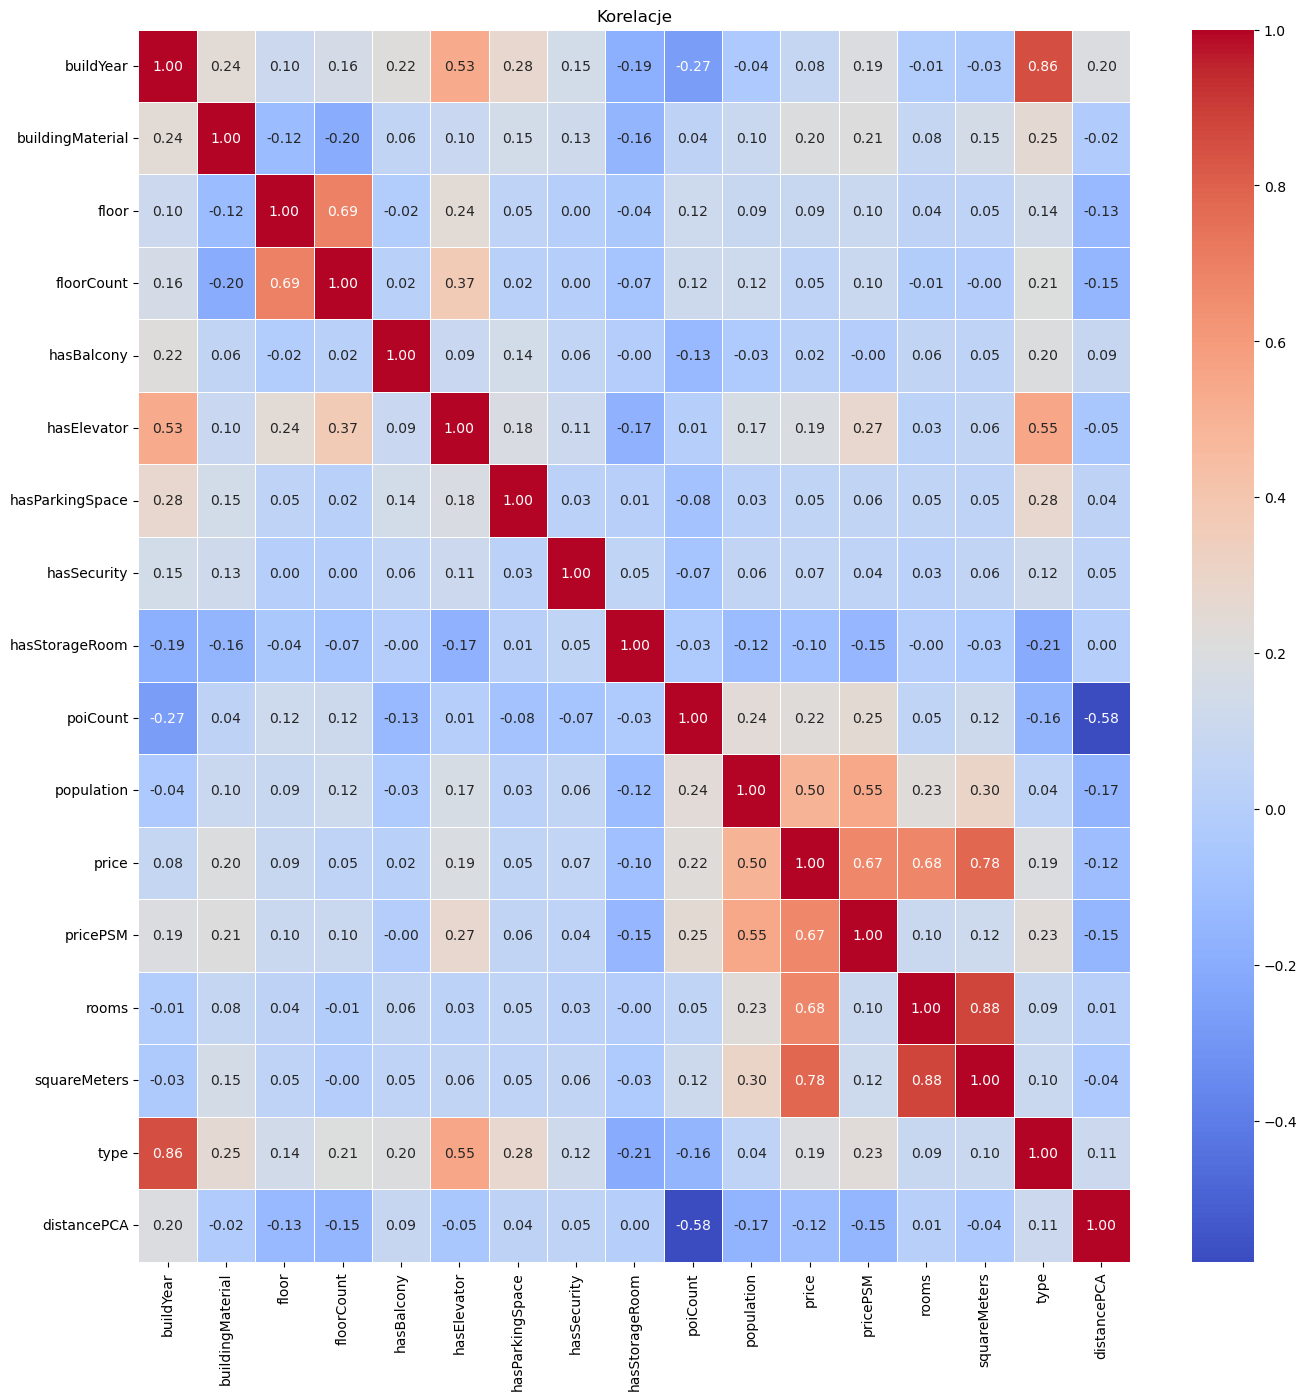

In [14]:
# macierz korelacji dla nowej tabeli
rent2_corr_matrix = rent2.corr()

# heatmapa korelacji
plt.figure(figsize=(16, 16))
sns.heatmap(rent2_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelacje')
plt.show()

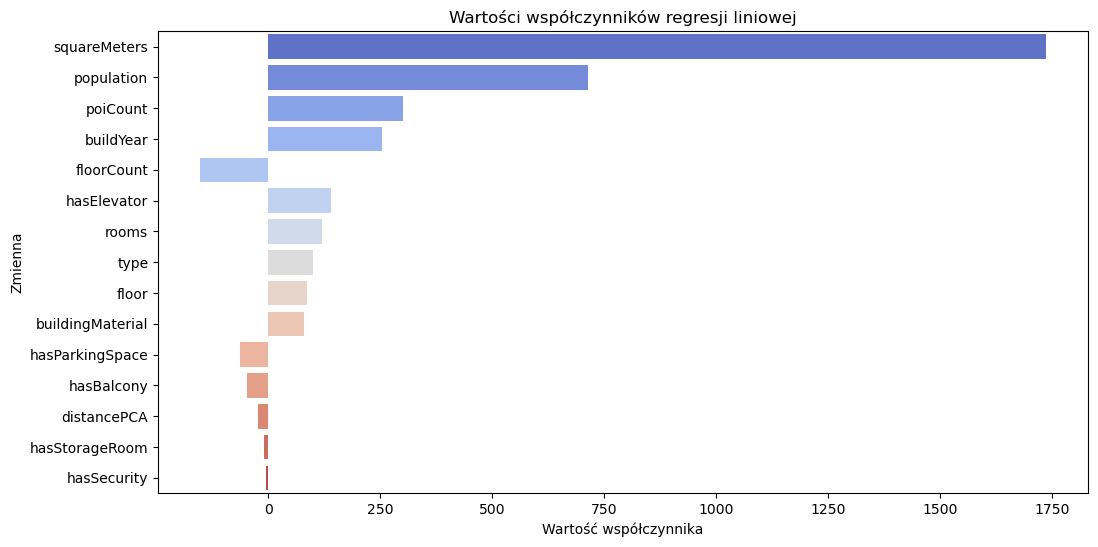

Przecięcie (intercept): 4300.98839875478


In [15]:
# usuwamy kolumnę z ceną całkowitą - nie będzie nam już potrzebna
rent2 = rent2.drop(columns=['pricePSM'])

# zmienna zależna (y) to 'price', a zmienne niezależne (X) to pozostałe kolumny
X = rent2.drop('price', axis=1)
y = rent2['price'].values

# skalowanie danych, aby wpływały na model w sposób zrównoważony
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# podział danych na zbiór uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# inicjalizacja modelu regresji liniowej
model = LinearRegression()

# trenowanie modelu na zbiorze uczącym
model.fit(X_train, y_train)

# tworzymy df z współczynnikami regresji i odpowiadającymi im kolumnami
coef_df = pd.DataFrame({'Variables': X.columns, 'Coefficients': model.coef_})

# sortujemy według wartości bezwzględnych współczynników
coef_df = coef_df.reindex(coef_df['Coefficients'].abs().sort_values(ascending=False).index)

# wizualizacja
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficients', y='Variables', data=coef_df, palette='coolwarm')
plt.title('Wartości współczynników regresji liniowej')
plt.xlabel('Wartość współczynnika')
plt.ylabel('Zmienna')
plt.show()

print(f'Przecięcie (intercept): {model.intercept_}')

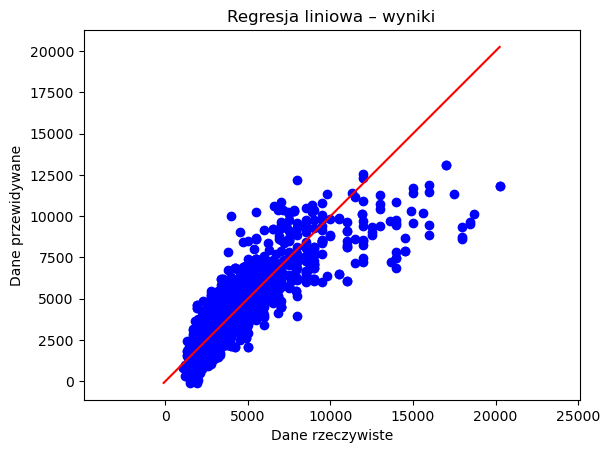

In [16]:
# przewidywanie na zbiorze testowym
y_pred = model.predict(X_test)

# dodanie prostej y=x do wykresu
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

# wykres danych rzeczywistych vs przewidywanych
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Dane rzeczywiste')
plt.ylabel('Dane przewidywane')
plt.title('Regresja liniowa – wyniki')
plt.axis('equal')
plt.show()

In [17]:
# analiza jakości modelu
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Pierwiastek błędu średniokwadratowego (RMSE): {rmse}')
print(f'R^2 (współczynnik determinacji): {r2}')

Pierwiastek błędu średniokwadratowego (RMSE): 1424.3762055740292
R^2 (współczynnik determinacji): 0.7042177822184092


In [18]:
# test F na istotność modelu ogółem
f_statistic_model, p_value_model = f_regression(X_test, y_test)
print(f"F-statistic: {f_statistic_model[0]}")
print(f"P-value: {p_value_model[0]}")

F-statistic: 1.484593602590391
P-value: 0.22321633206181607


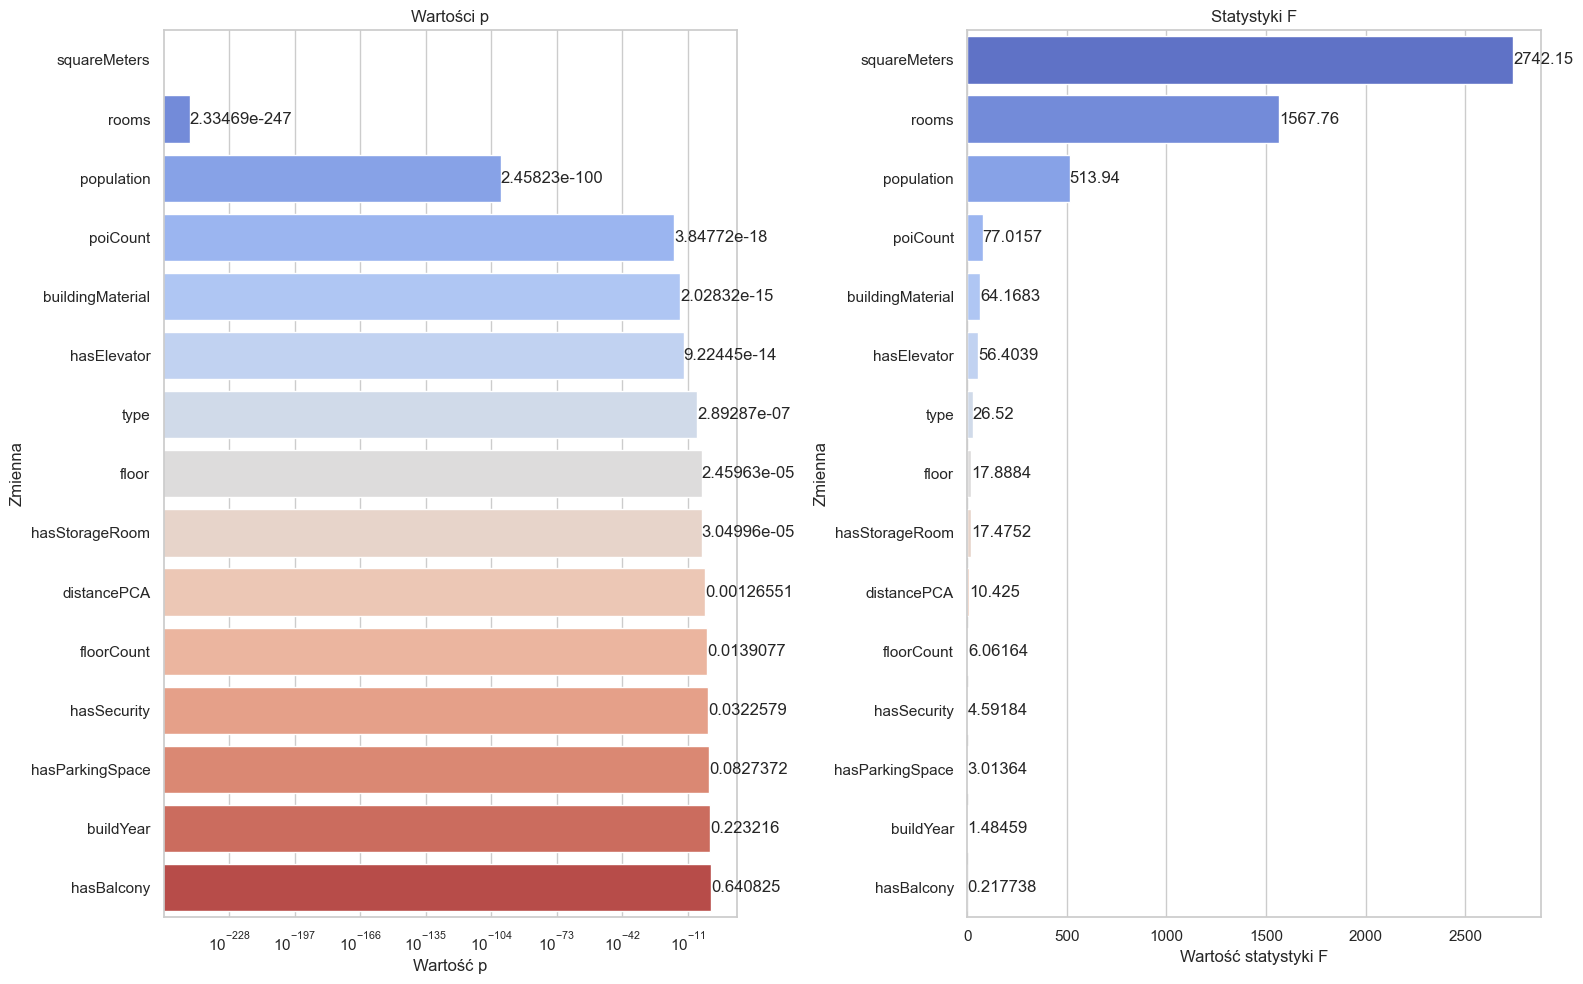

In [19]:
# tworzymy df z wartościami p, statystykami F i odpowiadającymi im kolumnami
statistic_df = pd.DataFrame({'Variables': X.columns, 'F-statistics': f_statistic_model, 'p-values': p_value_model})

# sortujemy według wartości p
statistic_df = statistic_df.reindex(statistic_df['p-values'].sort_values().index)

# wizualizacja
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")

ax1 = plt.subplot(1, 2, 1)
sns.barplot(x='p-values', y='Variables', data=statistic_df, palette='coolwarm', ax=ax1)
ax1.set_title('Wartości p')
ax1.set_xlabel('Wartość p')
ax1.set_ylabel('Zmienna')
ax1.set_xscale('log')
ax1.bar_label(ax1.containers[0])

ax2 = plt.subplot(1, 2, 2)
sns.barplot(x='F-statistics', y='Variables', data=statistic_df, palette='coolwarm', ax=ax2)
ax2.set_title('Statystyki F')
ax2.set_xlabel('Wartość statystyki F')
ax2.set_ylabel('Zmienna')
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.show()

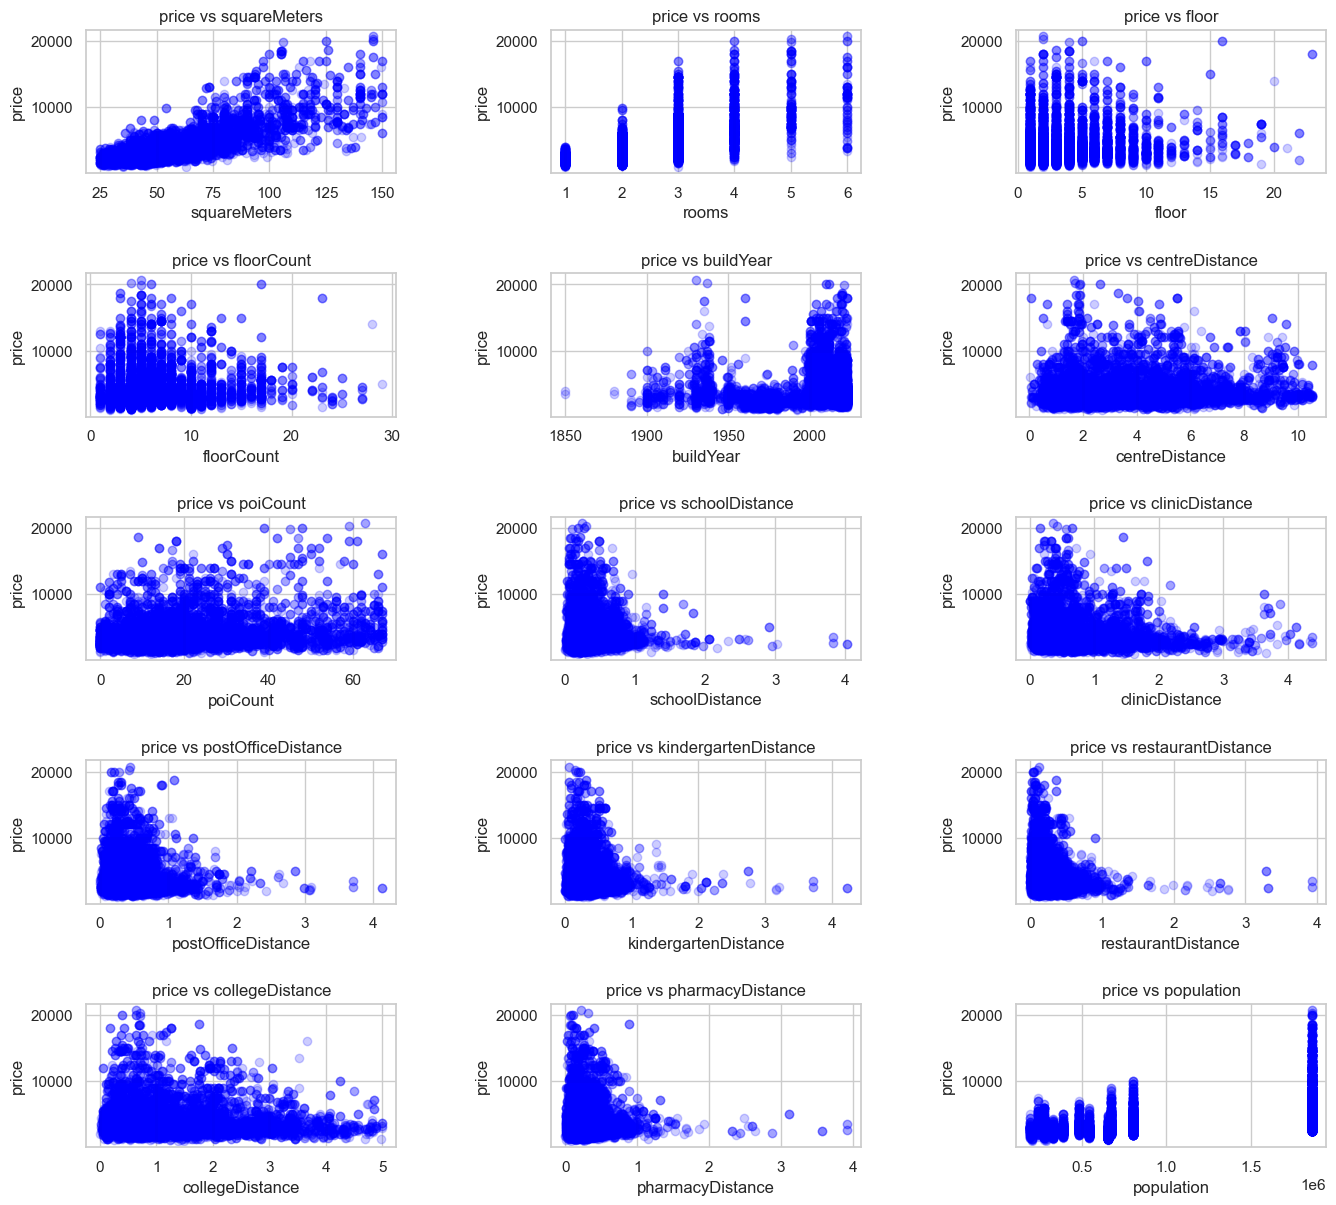

In [20]:
# scatterplot aby zobaczyć relacje price z innymi zmiennymi numerycznymi
plt.figure(figsize = (16, 24))
num_features.remove('price')
num_features.remove('pricePSM')
for i in range(0, len(num_features)):
    plt.subplot(8,3, i+1)
    plt.scatter(rent[num_features[i]], rent['price'], color='blue', alpha=0.2)
    plt.title(f'price vs {num_features[i]}')
    plt.xlabel(num_features[i])
    plt.ylabel('price')
    plt.subplots_adjust(wspace=0.5, hspace=0.7)

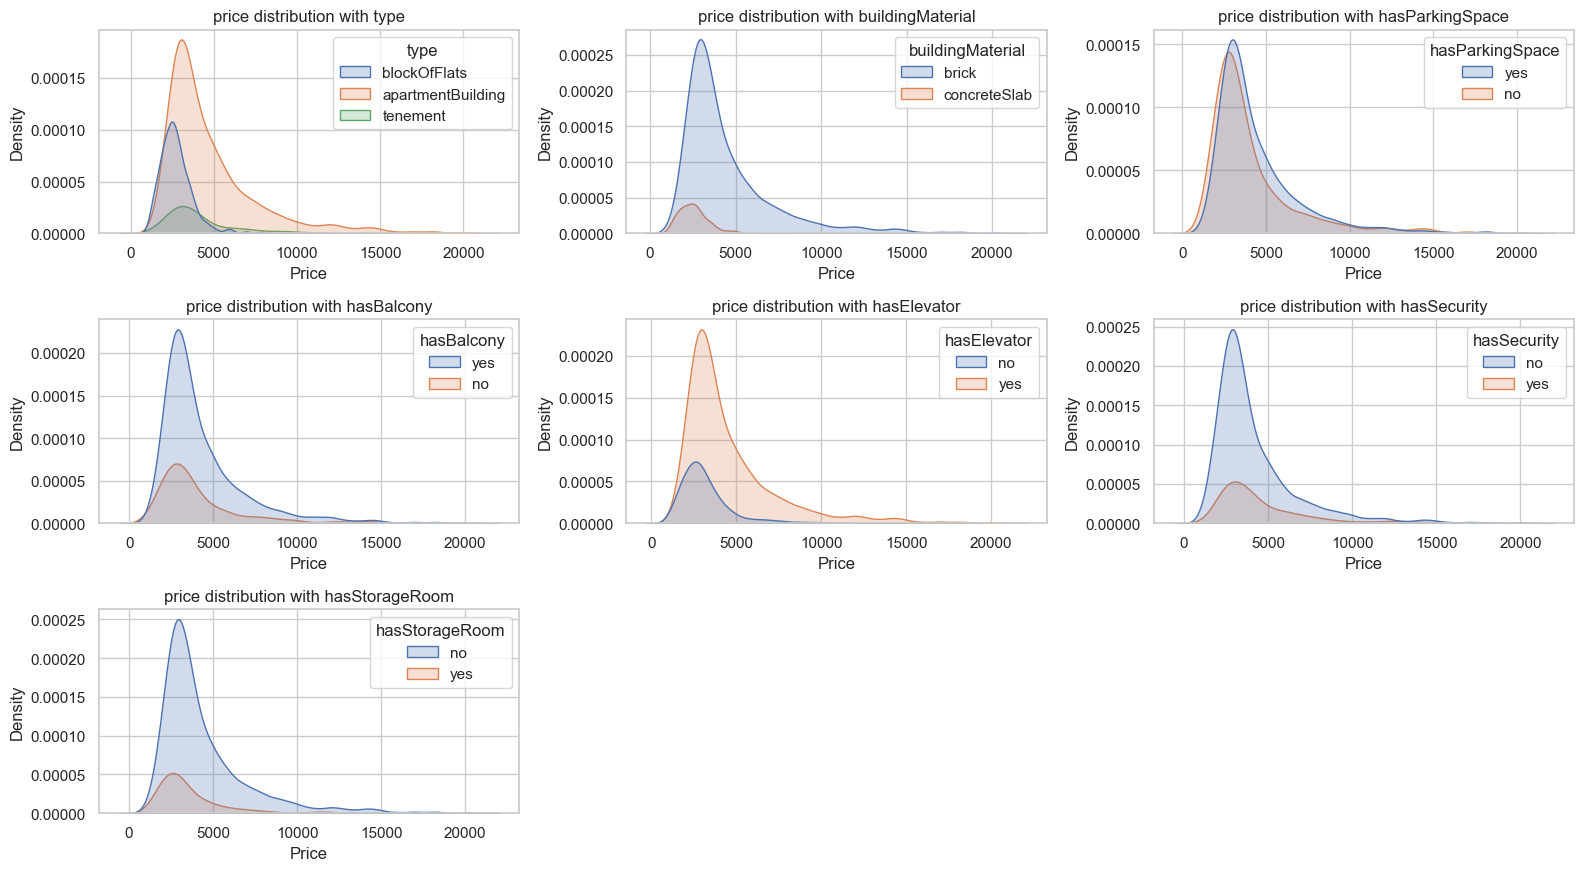

In [21]:
# kdeplot aby zobaczyć relacje price z innymi zmiennymi kategorialnymi
plt.figure(figsize=(16, 20))

for i, column in enumerate(cat_features, 1):
    plt.subplot(7, 3, i)
    sns.kdeplot(data=rent_og, x='price', hue=column, fill=True, color='coolwarm')
    plt.title(f'price distribution with {column}')
    plt.xlabel('Price')    
plt.tight_layout()
plt.show()